In [ ]:
""" Only use to run in Kaggle 

!pip uninstall -y scikit-learn xgboost

!pip install scikit-learn==1.4.2
!pip install xgboost==2.0.3
!pip install autogluon.tabular """

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data analysis and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LinearRegression
from autogluon.tabular import TabularPredictor

# Loadind dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

target_df = train_df[['PassengerId', 'Transported']]

complete_df = pd.concat([train_df.drop('Transported', axis=1), test_df], axis=0, ignore_index=True)

In this project, we explore the Spaceship Titanic dataset from Kaggle — a science fiction–themed variation of the classic Titanic survival prediction challenge. The goal is to predict whether passengers aboard the interstellar spaceship Titanic were transported to another dimension after the collision with a spacetime anomaly using records recovered from the spaceship’s damaged computer system.

## EDA - Spaceship Dataset

We begin this project with an Exploratory Data Analysis (EDA) to gain a deeper understanding of the dataset and the variables it contains. This process involves identifying key patterns and relationships that might influence the final classification outcome. 

To achieve this, we perform a feature engineering process where multiple new variables are created from existing data, providing greater diversity and depth to the dataset. We also handle missing values, since the dataset contains incomplete or corrupted entries that could affect model performance. Once the data is cleaned and enriched, we proceed with data visualization to explore these patterns and relationships visually.

All these steps will help us uncover insights about the passengers’ profiles and how these factors may relate to their probability of being transported.

**Variables Qualitatives:**

* Nominal: Name, PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Transported
* Ordinal: -
 
**Variables Quantitatives:**
* Continuous: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
* Discrete: Age

In [5]:
complete_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [6]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


In [7]:
complete_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
print(f'Dataset Nulls:\n\n{complete_df.isnull().sum()}')

Dataset Nulls:

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
dtype: int64


### Feature Engineering

Before proceeding to data visualization and modeling, it is crucial to refine and enrich the dataset to maximize its predictive power.

In this phase, we create multiple new features derived from the existing ones to capture deeper relationships and hidden patterns that may not be immediately apparent in the raw data. 

These engineered variables help provide the model with richer information and more diverse perspectives, ultimately improving its ability to make accurate predictions.

#### PassengerID

In [9]:
# New features based on PassengerID
complete_df['GroupId'] = complete_df['PassengerId'].str.split('_').str[0].astype(int)

group_sizes = complete_df['GroupId'].value_counts()
complete_df['GroupSize'] = complete_df['GroupId'].map(group_sizes)

complete_df['Solo'] = (complete_df['GroupSize'] == 1)

#### Cabin

In [10]:
# New features based on Cabin
complete_df['Cabin'] = complete_df['Cabin'].fillna('Unknown/Unknown/Unknown')

complete_df['CabinDeck'] = complete_df['Cabin'].str.split('/').str[0]
complete_df['CabinNum'] = pd.to_numeric(complete_df['Cabin'].str.split('/').str[1], errors="coerce").fillna(-1).astype(int)
complete_df['CabinSide'] = complete_df['Cabin'].str.split('/').str[2]

# Adding NaN again
complete_df['Cabin'] = complete_df['Cabin'].replace('Unknown/Unknown/Unknown', np.nan)
complete_df['CabinDeck'] = complete_df['CabinDeck'].replace('Unknown', np.nan)
complete_df['CabinSide'] = complete_df['CabinSide'].replace('Unknown', np.nan)
complete_df['CabinNum'] = complete_df['CabinNum'].replace(-1, np.nan)

#### Expenses

In [11]:
# New feature with the total spend on services, controlling the NaN
expenses_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

total_exp = complete_df[expenses_cols].fillna(0).sum(axis=1)
all_nan_mask = complete_df[expenses_cols].isna().all(axis=1)
complete_df['TotalExpense'] = total_exp.mask(all_nan_mask, np.nan)

#### Name

In [12]:
# New feature with just the surname of the people
complete_df['Surname'] = complete_df['Name'].str.split(' ').str[1]

In [13]:
complete_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,1,1,True,B,0.0,P,0.0,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,2,1,True,F,0.0,S,736.0,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,3,2,False,A,0.0,S,10383.0,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,3,2,False,A,0.0,S,5176.0,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,4,1,True,F,1.0,S,1091.0,Santantines


### Missing Values

The Space Titanic dataset contains several incomplete or corrupted entries that could introduce bias or reduce model performance if left untreated.

In this section, we apply appropriate imputation techniques based on the statistical nature and context of each variable, ensuring that missing values are filled in a way that preserves the underlying data distribution and relationships. 

This cleaning process results in a more robust and balanced dataset for subsequent analysis and modeling.

#### HomePlanet

In [14]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 288


In [15]:
# Checking if all people in the same group come from the same planet
group_planet_counts = complete_df.groupby("GroupId")["HomePlanet"].nunique().value_counts().reset_index()

group_planet_counts.columns = ['DifNumPlanetas', 'NumGroups']
group_planet_counts

,DifNumPlanetas,NumGroups
0,1,9124
1,0,156


In [16]:
# Filling the nan planet with people who know someone in the group
group_planet = complete_df.groupby("GroupId")["HomePlanet"].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan)

home_mask = complete_df["HomePlanet"].isna() & complete_df["GroupId"].isin(group_planet.dropna().index)
complete_df.loc[home_mask, "HomePlanet"] = complete_df.loc[home_mask, "GroupId"].map(group_planet)

In [17]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 157


In [18]:
# Checking if all people with the same last name come from the same planet
surname_group_counts = complete_df.groupby("Surname")["HomePlanet"].nunique().value_counts().reset_index()

surname_group_counts.columns = ['DifNumHomes', 'NumSurnames']
surname_group_counts

,DifNumHomes,NumSurnames
0,1,2400
1,0,6


In [19]:
# Filling the planet nan with people who share the same last name
surname_planet = complete_df.groupby("Surname")["HomePlanet"].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan)

surname_mask = complete_df["HomePlanet"].isna() & complete_df["Surname"].notna() & complete_df["Surname"].isin(surname_planet.dropna().index)
complete_df.loc[surname_mask, "HomePlanet"] = complete_df.loc[surname_mask, "Surname"].map(surname_planet)

In [20]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 13


In [21]:
# Checking for decks with only one HomePlanet
deck_planet_list = complete_df.groupby("CabinDeck")["HomePlanet"].unique().reset_index()

deck_planet_list.columns = ['CabinDeck', 'Planetas']
deck_planet_list

,CabinDeck,Planetas
0,A,"[Europa, nan]"
1,B,[Europa]
2,C,"[Europa, nan]"
3,D,"[Mars, Europa, nan]"
4,E,"[Earth, Mars, Europa, nan]"
5,F,"[Earth, Mars, nan]"
6,G,"[Earth, nan]"
7,T,[Europa]


In [22]:
# In decks A, B, C, and T there is only Europe, and in G there is only Earth
deck_eur_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['A', 'B', 'C', 'T'])
complete_df.loc[deck_eur_mask, "HomePlanet"] = 'Europa'

deck_ear_mask = complete_df["HomePlanet"].isna() & (complete_df["CabinDeck"]=='G')
complete_df.loc[deck_ear_mask, "HomePlanet"] = 'Earth'

In [23]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 10


In [24]:
# Checking passengers with HomePlanet nan
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(complete_df[complete_df['HomePlanet'].isna()])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
2274,2443_01,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,...,0.0,NaN,2443,1,True,D,72.0,P,1955.0,NaN
2631,2817_01,NaN,False,F/584/P,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,...,12.0,Sealfs Sutty,2817,1,True,F,584.0,P,1159.0,Sutty
3091,3331_01,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,...,50.0,NaN,3331,1,True,F,631.0,S,803.0,NaN
4548,4840_01,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,...,0.0,NaN,4840,1,True,F,915.0,S,0.0,NaN
5762,6108_01,NaN,False,F/1166/S,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,...,629.0,NaN,6108,1,True,F,1166.0,S,864.0,NaN
8969,0616_01,NaN,False,E/40/S,TRAPPIST-1e,31.0,False,0.0,428.0,NaN,...,1025.0,Arkaban Spriney,616,1,True,E,40.0,S,2607.0,Spriney
10583,4052_01,NaN,False,D/136/P,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,...,72.0,Ankabih Coneveseng,4052,1,True,D,136.0,P,6221.0,Coneveseng
11913,7065_01,NaN,True,E/471/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,NaN,Zedares Maltorted,7065,1,True,E,471.0,S,0.0,Maltorted
12551,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,...,1216.0,NaN,8435,1,True,F,1730.0,P,1389.0,NaN
12725,8775_01,NaN,True,D/275/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,...,0.0,Raston Maltorted,8775,1,True,D,275.0,P,0.0,Maltorted


In [25]:
# Filtering passengers bound for TRAPPIST by planet of origin
origin_distribution = complete_df[complete_df['Destination'] == 'TRAPPIST-1e']['HomePlanet'].value_counts(dropna=False).reset_index()

origin_distribution.columns = ['HomePlanet', 'NumPasajeros']
origin_distribution

,HomePlanet,NumPasajeros
0,Earth,4778
1,Mars,2314
2,Europa,1769
3,NaN,10


In [26]:
# Assigning the home planet based on deck trends and distribution
ear_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['E', 'F', 'G'])
complete_df.loc[ear_mask, 'HomePlanet'] = 'Earth'

mar_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['D'])
complete_df.loc[mar_mask, 'HomePlanet'] = 'Mars'

eur_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['A', 'B', 'C', 'T'])
complete_df.loc[eur_mask, 'HomePlanet'] = 'Europa'

In [27]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 0


#### Destination

In [28]:
print(f'Destination Nulls: {complete_df["Destination"].isnull().sum()}')

Destination Nulls: 274


In [29]:
# Checking for groups with more than one destination
group_cabin_counts = complete_df.groupby("GroupId")["Destination"].nunique().value_counts().reset_index()

group_cabin_counts.columns = ["DifNumDestinos", "NumGroups"]
group_cabin_counts

,DifNumDestinos,NumGroups
0,1,8056
1,2,997
2,0,154
3,3,73


In [30]:
# Since most groups only have one destination, we fill in the nan according to the group's mode
group_destination_mode = complete_df.groupby("GroupId")["Destination"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

destination_mask = complete_df["Destination"].isna() & complete_df["GroupId"].isin(group_destination_mode.dropna().index)
complete_df.loc[destination_mask, "Destination"] = complete_df.loc[destination_mask, "GroupId"].map(group_destination_mode)

In [31]:
print(f'Destination Nulls: {complete_df["Destination"].isnull().sum()}')

Destination Nulls: 154


In [32]:
# Filling the remaining nans according to the mode of their planet of origin
home_destination_mode = complete_df.groupby("HomePlanet")["Destination"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

destination_mask = complete_df["Destination"].isna() & complete_df["HomePlanet"].isin(home_destination_mode.dropna().index)
complete_df.loc[destination_mask, "Destination"] = complete_df.loc[destination_mask, "HomePlanet"].map(home_destination_mode)

In [33]:
print(f'Destination Nulls: {complete_df["Destination"].isnull().sum()}')

Destination Nulls: 0


#### Surname

In [34]:
print(f'Surname Nulls: {complete_df["Surname"].isnull().sum()}')

Surname Nulls: 294


In [35]:
# Checking whether all people in the same group have the same last name
group_surnames_counts = complete_df.groupby("GroupId")["Surname"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['DifNumSurnames', 'NumGroups']
group_surnames_counts

,DifNumSurnames,NumGroups
0,1,8759
1,2,322
2,0,155
3,3,43
4,4,1


In [36]:
# Filling the surnames nan with the mode of their groups
group_surname_mode = complete_df.groupby("GroupId")["Surname"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

surname_mask = complete_df["Surname"].isna() & complete_df["GroupId"].isin(group_surname_mode.dropna().index)
complete_df.loc[surname_mask, "Surname"] = complete_df.loc[surname_mask, "GroupId"].map(group_surname_mode)

In [37]:
print(f'Surname Nulls: {complete_df["Surname"].isnull().sum()}')

Surname Nulls: 155


In [38]:
# Checking whether all people with the same last name belong to the same group
surname_group_counts = complete_df.groupby("Surname")["GroupId"].nunique().value_counts().reset_index()

surname_group_counts.columns = ['DifNumGroups', 'NumSurnames']
surname_group_counts

# There are groups with different last names, and last names spread across different groups

,DifNumGroups,NumSurnames
0,2,457
1,3,404
2,1,341
3,4,340
4,5,269
5,6,224
6,7,159
7,8,98
8,9,60
9,10,27


#### CabinSide

In [39]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 299


In [40]:
# Checking if everyone in the same group has the same CabinSide
group_surnames_counts = complete_df.groupby("GroupId")["CabinSide"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['DifNumCabinSide', 'NumGroups']
group_surnames_counts

,DifNumCabinSide,NumGroups
0,1,9119
1,0,161


In [41]:
# Filling the CabinSide nan with people from the same group
group_side = complete_df.groupby("GroupId")["CabinSide"].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan)

side_mask = complete_df["CabinSide"].isna() & complete_df["GroupId"].isin(group_side.dropna().index)
complete_df.loc[side_mask, "CabinSide"] = complete_df.loc[side_mask, "GroupId"].map(group_side)

In [42]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 162


In [43]:
# Checking if all people with the same surname have the same CabinSide
group_surnames_counts = complete_df.groupby("Surname")["CabinSide"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['DifNumCabinSide', 'NumSurnames']
group_surnames_counts

,DifNumCabinSide,NumSurnames
0,2,1632
1,1,770
2,0,4


In [44]:
# Checking the percentage of surnames that are concentrated mainly on one side
surname_counts = complete_df.groupby(["Surname", "CabinSide"]).size().unstack(fill_value=0)
surname_counts = surname_counts[surname_counts.sum(axis=1) > 1]

dominance_ratio = surname_counts.max(axis=1) / surname_counts.sum(axis=1)

percent_majority_side = (dominance_ratio > 0.5).mean() * 100
print(f"{percent_majority_side:.2f}% of families have the majority on one side")

87.61% of families have the majority on one side


In [45]:
# Although most surnames are distributed mostly on the same side, we fill in the surnames that are distributed mostly on one side
surname_side_mode = complete_df.groupby("Surname")["CabinSide"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

side_mask = complete_df["CabinSide"].isna() & complete_df["Surname"].notna() & complete_df["Surname"].isin(surname_side_mode.dropna().index)
complete_df.loc[side_mask, "CabinSide"] = complete_df.loc[side_mask, "Surname"].map(surname_side_mode)

In [46]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 5


In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(complete_df[complete_df["CabinSide"].isnull()])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
462,0502_01,Mars,False,NaN,TRAPPIST-1e,22.0,False,10.0,0.0,817.0,...,0.0,Pigars Swell,502,1,True,NaN,NaN,NaN,1298.0,Swell
1980,2117_01,Europa,False,NaN,TRAPPIST-1e,31.0,False,0.0,8718.0,0.0,...,267.0,Azet Rocketedy,2117,1,True,NaN,NaN,NaN,22021.0,Rocketedy
3308,3553_01,Mars,False,NaN,TRAPPIST-1e,28.0,False,3.0,0.0,0.0,...,2054.0,Wafox Maie,3553,1,True,NaN,NaN,NaN,2384.0,Maie
6037,6385_01,Mars,False,NaN,PSO J318.5-22,21.0,False,435.0,0.0,422.0,...,0.0,Possh Duncy,6385,1,True,NaN,NaN,NaN,873.0,Duncy
10257,3367_01,Earth,False,NaN,TRAPPIST-1e,28.0,False,0.0,818.0,51.0,...,0.0,NaN,3367,1,True,NaN,NaN,NaN,869.0,NaN


In [48]:
# Filling in the last nan records with an unknown value X
complete_df.loc[complete_df['CabinSide'].isnull(), 'CabinSide']='X'

In [49]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 0


#### CabinDeck

In [50]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 299


In [51]:
# Checking if everyone in the same group has the same CabinSide
group_surnames_counts = complete_df.groupby("GroupId")["CabinDeck"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['DifNumCabinDeck', 'NumGroups']
group_surnames_counts

,DifNumCabinDeck,NumGroups
0,1,8446
1,2,640
2,0,161
3,3,33


In [52]:
# Filling the deck according to your group's style
group_deck_mode = complete_df.groupby("GroupId")["CabinDeck"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

deck_mask = complete_df["CabinDeck"].isna() & complete_df["GroupId"].isin(group_deck_mode.dropna().index)
complete_df.loc[deck_mask, "CabinDeck"] = complete_df.loc[deck_mask, "GroupId"].map(group_deck_mode)

In [53]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 162


In [54]:
# Checking the distribution of people according to HomePlanet and CabinDeck
planet_deck_counts = complete_df.groupby(["HomePlanet", "CabinDeck"]).size().reset_index(name="NumPersonas")
planet_deck_counts

,HomePlanet,CabinDeck,NumPersonas
0,Earth,E,601
1,Earth,F,2496
2,Earth,G,3821
3,Europa,A,361
4,Europa,B,1161
5,Europa,C,1122
6,Europa,D,309
7,Europa,E,204
8,Europa,T,11
9,Mars,D,421


In [55]:
# Filling the deck with mode according to Homeplanet, except in Europe, where there is a similar distribution between B and C
planet_deck_mode = complete_df.groupby("HomePlanet")["CabinDeck"].agg(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

deck_mask = complete_df["CabinDeck"].isna() & (complete_df["HomePlanet"] != "Europa")
complete_df.loc[deck_mask, "CabinDeck"] = complete_df.loc[deck_mask, "HomePlanet"].map(planet_deck_mode)

In [56]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 29


In [57]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(complete_df[complete_df["CabinDeck"].isnull()])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,...,241.0,Naviton Coudered,310,1,True,NaN,NaN,P,4947.0,Coudered
344,0380_01,Europa,True,NaN,55 Cancri e,26.0,False,0.0,0.0,0.0,...,0.0,Zinopus Fuelddid,380,1,True,NaN,NaN,S,0.0,Fuelddid
691,0715_01,Europa,NaN,NaN,55 Cancri e,54.0,False,0.0,0.0,0.0,...,0.0,Izarfik Unconary,715,1,True,NaN,NaN,P,0.0,Unconary
793,0833_01,Europa,True,NaN,55 Cancri e,36.0,False,0.0,0.0,0.0,...,0.0,Tarmus Poicaptic,833,1,True,NaN,NaN,P,0.0,Poicaptic
980,1041_01,Europa,True,NaN,TRAPPIST-1e,46.0,False,0.0,0.0,0.0,...,0.0,Algrafi Heedry,1041,1,True,NaN,NaN,P,0.0,Heedry
1029,1095_01,Europa,True,NaN,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,...,0.0,Alhail Drelcate,1095,1,True,NaN,NaN,P,0.0,Drelcate
1060,1134_01,Europa,True,NaN,55 Cancri e,13.0,False,0.0,0.0,0.0,...,0.0,Hadyon Sobvisted,1134,1,True,NaN,NaN,P,0.0,Sobvisted
1862,1984_01,Europa,False,NaN,55 Cancri e,37.0,False,0.0,3166.0,0.0,...,6.0,Mesath Wassid,1984,1,True,NaN,NaN,P,3263.0,Wassid
1980,2117_01,Europa,False,NaN,TRAPPIST-1e,31.0,False,0.0,8718.0,0.0,...,267.0,Azet Rocketedy,2117,1,True,NaN,NaN,X,22021.0,Rocketedy
2382,2559_01,Europa,False,NaN,TRAPPIST-1e,51.0,False,0.0,1949.0,0.0,...,39.0,Castab Clarty,2559,1,True,NaN,NaN,S,4537.0,Clarty


In [58]:
# All remaining nan from Europe travel alone and are not VIPs
europa_solos_noVIP = complete_df[(complete_df["HomePlanet"] == "Europa") & (complete_df["VIP"] == False) & (complete_df["GroupSize"] == 1)]
europa_solos_noVIP.groupby("CabinDeck").size().reset_index(name="NumPersonas")

,CabinDeck,NumPersonas
0,A,96
1,B,285
2,C,340
3,D,124
4,E,112
5,T,8


In [59]:
# Filling the deck with fashion for singles and non-VIPs in Europe
soloVIP_mode = europa_solos_noVIP["CabinDeck"].mode().iloc[0]

nan_europa_mask = complete_df["CabinDeck"].isna() & (complete_df["HomePlanet"] == "Europa")
complete_df.loc[nan_europa_mask, 'CabinDeck'] = soloVIP_mode

In [60]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 0


 #### CabinNumber

In [61]:
print(f'CabinNum Nulls: {complete_df["CabinNum"].isnull().sum()}')

CabinNum Nulls: 299


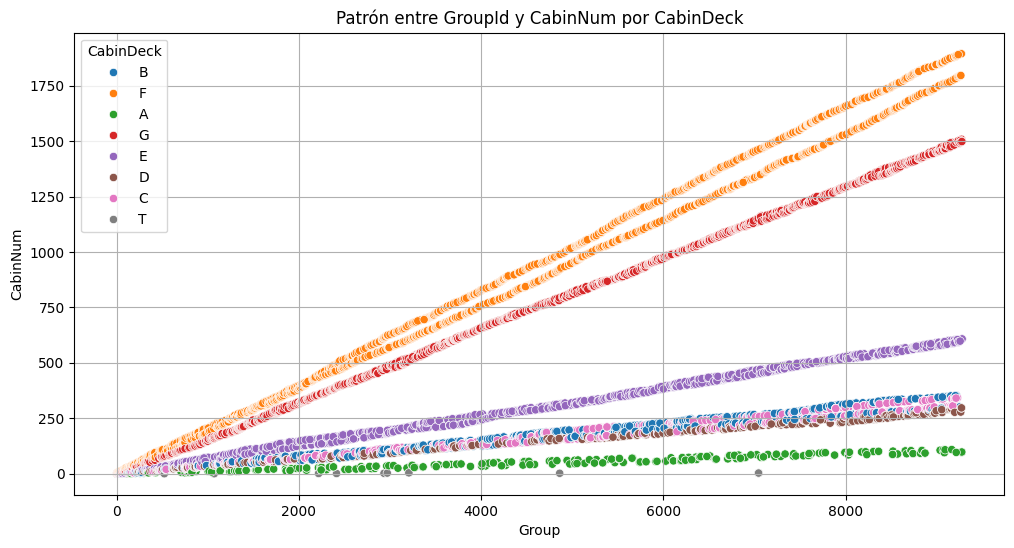

In [62]:
# Studying whether there is any pattern between the group number and the deck
plt.figure(figsize=(12,6))
sns.scatterplot(data=complete_df, x='GroupId', y='CabinNum', hue='CabinDeck')
plt.title('Patrón entre GroupId y CabinNum por CabinDeck')
plt.xlabel('Group')
plt.ylabel('CabinNum')
plt.legend(title='CabinDeck')
plt.grid(True)
plt.show()

In [63]:
# There is a clear linear pattern between the cabin number and the group number on each deck
# We will use this to fill in the NaN variables for the missing cabin numbers
missing = complete_df.loc[complete_df['CabinNum'].isna(), 'CabinDeck'].unique()
known = complete_df.loc[complete_df['CabinNum'].notna(), 'CabinDeck'].unique()

for deck in list(set(missing) & set(known)):
    mask_deck = complete_df['CabinDeck'] == deck
        
    x_train = complete_df.loc[mask_deck & complete_df['CabinNum'].notna(), 'GroupId']
    y_train = complete_df.loc[mask_deck & complete_df['CabinNum'].notna(), 'CabinNum']
    x_test = complete_df.loc[mask_deck & complete_df['CabinNum'].isna(), 'GroupId']

    model = LinearRegression()
    model.fit(x_train.values.reshape(-1, 1), y_train.values)

    preds = model.predict(x_test.values.reshape(-1, 1))
    
    preds = np.round(preds).astype(int)
    preds = np.clip(preds, a_min=0, a_max=2000)

    complete_df.loc[mask_deck & complete_df['CabinNum'].isna(), 'CabinNum'] = preds

In [64]:
print(f'CabinNum Nulls: {complete_df["CabinNum"].isnull().sum()}')

CabinNum Nulls: 0


In [65]:
# Addition of a variable with cabin sectors
bins = [-1, 300, 600, 900, 1200, 1500, 1800, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7]
complete_df['CabinSector'] = pd.cut(complete_df['CabinNum'], bins=bins, labels=labels)

#### VIP

In [66]:
print(f'VIP Nulls: {complete_df["VIP"].isnull().sum()}')

VIP Nulls: 296


In [67]:
# Checking the total number of VIPs
complete_df['VIP'].value_counts().reset_index(name="NumPersonas")

,VIP,NumPersonas
0,False,12401
1,True,273


In [68]:
# Since the vast majority are not VIPs, we fill the nan with it
complete_df.loc[complete_df['VIP'].isna(), 'VIP'] = False

In [69]:
print(f'VIP Nulls: {complete_df["VIP"].isnull().sum()}')

VIP Nulls: 0


#### CryoSleep

In [70]:
print(f'CryoSleep Nulls: {complete_df["CryoSleep"].isnull().sum()}')

CryoSleep Nulls: 310


In [71]:
# Checking the distribution between people with expenses and cryosleep
complete_df['Spent'] = complete_df['TotalExpense'] > 0

complete_df.groupby(['Spent','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
Spent,,
False,740.0,4581.0
True,7339.0,0.0


In [72]:
# Those who are asleep do not spend, but those who are awake mostly do
awake_mask = complete_df['CryoSleep'].isna() & (complete_df['TotalExpense'] > 0)
complete_df.loc[awake_mask, 'CryoSleep'] = False

sleep_mask = complete_df['CryoSleep'].isna() & (complete_df['TotalExpense'] == 0)
complete_df.loc[sleep_mask, 'CryoSleep'] = True


In [73]:
print(f'CryoSleep Nulls: {complete_df["CryoSleep"].isnull().sum()}')

CryoSleep Nulls: 0


#### Expenses

In [74]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
dtype: int64 

TotalExpense Nulls: 0


In [75]:
# If you are in CryoSleep you can't have expenses
complete_df.loc[complete_df["CryoSleep"] == True, expenses_cols] = 0
complete_df.loc[complete_df["CryoSleep"] == True, 'TotalExpense'] = 0

# Filling the deck with fashion for singles and non-VIPs in Europe
soloVIP_mode = europa_solos_noVIP["CabinDeck"].mode().iloc[0]

nan_europa_mask = complete_df["CabinDeck"].isna() & (complete_df["HomePlanet"] == "Europa")
complete_df.loc[nan_europa_mask, 'CabinDeck'] = soloVIP_mode

In [76]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     170
FoodCourt       179
ShoppingMall    172
Spa             173
VRDeck          172
dtype: int64 

TotalExpense Nulls: 0


In [77]:
# Studying the internal standard deviation of each group's expenses and comparing it with the overall standard deviation
group_spread = complete_df[complete_df["GroupSize"] > 1].groupby("GroupId")[expenses_cols].std().mean(axis=1).reset_index(name="StdDev")

global_std = complete_df[expenses_cols].std().mean()

print("GLOBAL Standard deviation:", global_std)
print("INTRA-GROUP Standard deviation:", group_spread["StdDev"].mean())

# Expenses within the group are similar compared to the global total.

GLOBAL Standard deviation: 1022.6062011210543
INTRA-GROUP Standard deviation: 443.5383722358051


In [78]:
# Studying whether the distribution is balanced to use the mean or, if not, the median
stats = complete_df[complete_df["GroupSize"] > 1].groupby("GroupId")[expenses_cols].agg(['mean', 'median'])

mean_vals = stats.xs('mean', level=1, axis=1)
median_vals = stats.xs('median', level=1, axis=1)

valid = median_vals > 0
ratio = (mean_vals[valid] / median_vals[valid]).mean(axis=1)

ratio.describe()

# Due to outliers, it is better to use the median

count    1358.000000
mean        6.249724
std        25.129010
min         0.683228
25%         1.000000
50%         1.000000
75%         1.000000
max       559.595311
dtype: float64

In [79]:
# Filling in all expenses with the group median
for col in expenses_cols:
    group_median = complete_df[complete_df["GroupSize"] > 1].groupby('GroupId')[col].transform('median')
    
    mask_nan = complete_df[col].isna() & (complete_df["GroupSize"] > 1)
    complete_df.loc[mask_nan, col] = group_median[mask_nan]

In [80]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     117
FoodCourt       113
ShoppingMall     93
Spa             107
VRDeck          102
dtype: int64 

TotalExpense Nulls: 0


In [ ]:
# Studying the internal standard deviation of each surname's expenses and comparing it with the overall standard deviation
surname_spread = complete_df.groupby("Surname")[expenses_cols].std().mean(axis=1).reset_index(name="DispersionMedia")

global_std = complete_df[expenses_cols].std().mean()

print("GLOBAL Standard deviation:", global_std)
print("INTRA-SURNAME Standard deviation:", surname_spread["DispersionMedia"].mean())

# Expenses within the group are similar compared to the global total.

Desviación media GLOBAL: 1022.5903696170319
Desviación media INTRA-APELLIDO: 529.019717555048


In [82]:
# Studying whether the distribution is balanced to use the mean or, if not, the median
stats = complete_df.groupby("Surname")[expenses_cols].agg(['mean', 'median'])

mean_vals = stats.xs('mean', level=1, axis=1)
median_vals = stats.xs('median', level=1, axis=1)

median_vals_clean = median_vals.replace([np.inf, -np.inf], np.nan)

mean_vals_clean = mean_vals.replace([np.inf, -np.inf], np.nan)
median_vals_clean = median_vals.replace([np.inf, -np.inf], np.nan)

valid = median_vals_clean > 0
ratio = (mean_vals_clean[valid] / median_vals_clean[valid]).mean(axis=1)

ratio.describe()

# Due to outliers, it is better to use the median

count    1518.000000
mean       40.365112
std       119.391044
min         0.628205
25%         1.000000
50%         5.598267
75%        30.866328
max      1686.500000
dtype: float64

In [83]:
# Filling in all expenses with the surname median
for col in expenses_cols:
    surname_median = complete_df.groupby('Surname')[col].transform('median')
    
    mask_nan = complete_df[col].isna() & (complete_df["GroupSize"] == 1)
    complete_df.loc[mask_nan, col] = surname_median[mask_nan]

In [84]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     2
FoodCourt       5
ShoppingMall    3
Spa             2
VRDeck          3
dtype: int64 

TotalExpense Nulls: 0


In [85]:
# All remaining nan are filled according to the median of their HomePlanet for solo travelers
for col in expenses_cols:
    planet_median = complete_df[complete_df["GroupSize"] == 1].groupby("HomePlanet")[col].transform("median")
    
    mask = complete_df[col].isna() & (complete_df["GroupSize"] == 1)
    complete_df.loc[mask, col] = planet_median[mask]

In [86]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64 

TotalExpense Nulls: 0


In [87]:
# Updating TotalExpense and Spent
complete_df['TotalExpense'] = complete_df[expenses_cols].sum(axis=1)

complete_df['Spent'] = complete_df['TotalExpense'] > 0

#### Age

In [88]:
print(f'Age Nulls: {complete_df["Age"].isnull().sum()}')

Age Nulls: 270


In [89]:
# Studying the combination of variables that minimizes the standard deviation of age
subgroup_cols = ['GroupSize', 'HomePlanet', 'Destination', 'Spent', 'CryoSleep', 'VIP']

age_spread = complete_df.groupby(subgroup_cols)['Age'].std().reset_index(name="MeanDispersion")
global_std = complete_df['Age'].std()

print("GLOBAL Standard Deviation:", global_std)
print("INTRA-SURNAME Standard Deviation:", age_spread["MeanDispersion"].mean())

# The age in these subgroups is more similar than the overall average.

GLOBAL Standard Deviation: 14.387260917143353
INTRA-SURNAME Standard Deviation: 10.868963310000707


In [90]:
# Filling in the age with the mean of the subgroup
age_median_subgroup = complete_df.groupby(subgroup_cols)['Age'].transform('median')

age_nan_mask = complete_df['Age'].isna()
complete_df.loc[age_nan_mask, 'Age'] = age_median_subgroup[age_nan_mask]

In [91]:
print(f'Age Nulls: {complete_df["Age"].isnull().sum()}')

Age Nulls: 0


In [92]:
# Adding an age category featue
bins = [0, 12, 18, 30, 50, 80]
labels = ['Child','Teen','Young','Adult','Elder']
complete_df['AgeCategory'] = pd.cut(complete_df['Age'], bins=bins, labels=labels)

In [93]:
# Deleting all the irrelevant features for the models
complete_df = complete_df.drop(columns=['Cabin', 'Name','Surname'])

In [94]:
print(f'Total Nulls: \n\n{complete_df.isnull().sum()}')

Total Nulls: 

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
GroupId           0
GroupSize         0
Solo              0
CabinDeck         0
CabinNum          0
CabinSide         0
TotalExpense      0
CabinSector       0
Spent             0
AgeCategory     260
dtype: int64


In [95]:
complete_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupSize,CabinNum,TotalExpense
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.00000,12970.000000
mean,28.709483,219.667849,445.134194,171.846839,303.374595,303.223207,4635.337471,2.022976,603.21835,1443.246685
std,14.285075,642.540116,1572.792261,585.480777,1119.296198,1175.209268,2685.904299,1.577102,512.67006,2820.751173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2306.250000,1.000000,170.00000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4632.000000,1.000000,431.00000,717.000000
75%,37.000000,46.000000,69.000000,25.000000,53.000000,39.000000,6924.750000,2.000000,1008.00000,1445.750000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000,1894.00000,35987.000000


### Data Visualization

Before building any predictive model, it is essential to perform a thorough visual exploration of the dataset to better understand the relationships between features and the target variable. Visualization allows us to intuitively identify patterns, trends, and potential anomalies that may not be evident through numerical analysis alone.

In this section, we analyze the distribution of key variables to uncover potential correlations with the likelihood of being transported. By examining these relationships visually, we aim to gain a clearer picture of which factors might have the strongest impact on the outcome.

In [96]:
train_df = complete_df[complete_df['PassengerId'].isin(train_df['PassengerId'].values)].copy()
train_df = train_df.merge(target_df, on='PassengerId', how='left')

test_df = complete_df[complete_df['PassengerId'].isin(test_df['PassengerId'].values)].copy()

#### Global Rate of Transported Passengers

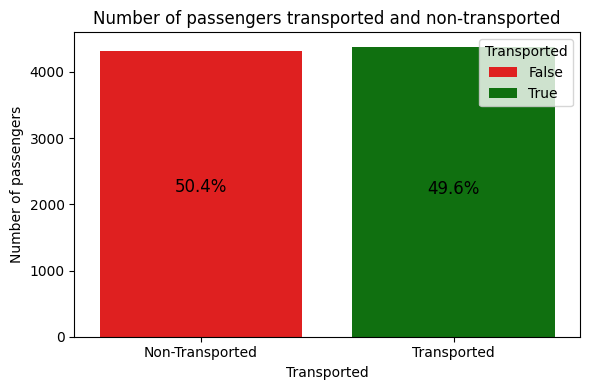

In [97]:
survival_counts = train_df['Transported'].value_counts()
survival_proportion = train_df['Transported'].value_counts(normalize=True)

plt.figure(figsize=(6,4))
sns.barplot(x=survival_counts.index, y=survival_counts.values, hue=survival_counts.index, palette=['red','green'])
plt.title('Number of passengers transported and non-transported')
plt.ylabel('Number of passengers')
plt.xticks([0,1], ['Non-Transported', 'Transported'])

for i, value in enumerate(survival_counts.values):
    percentage = survival_proportion.iloc[i] * 100
    plt.text(i, value/2, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

#### Transported Rate by Age

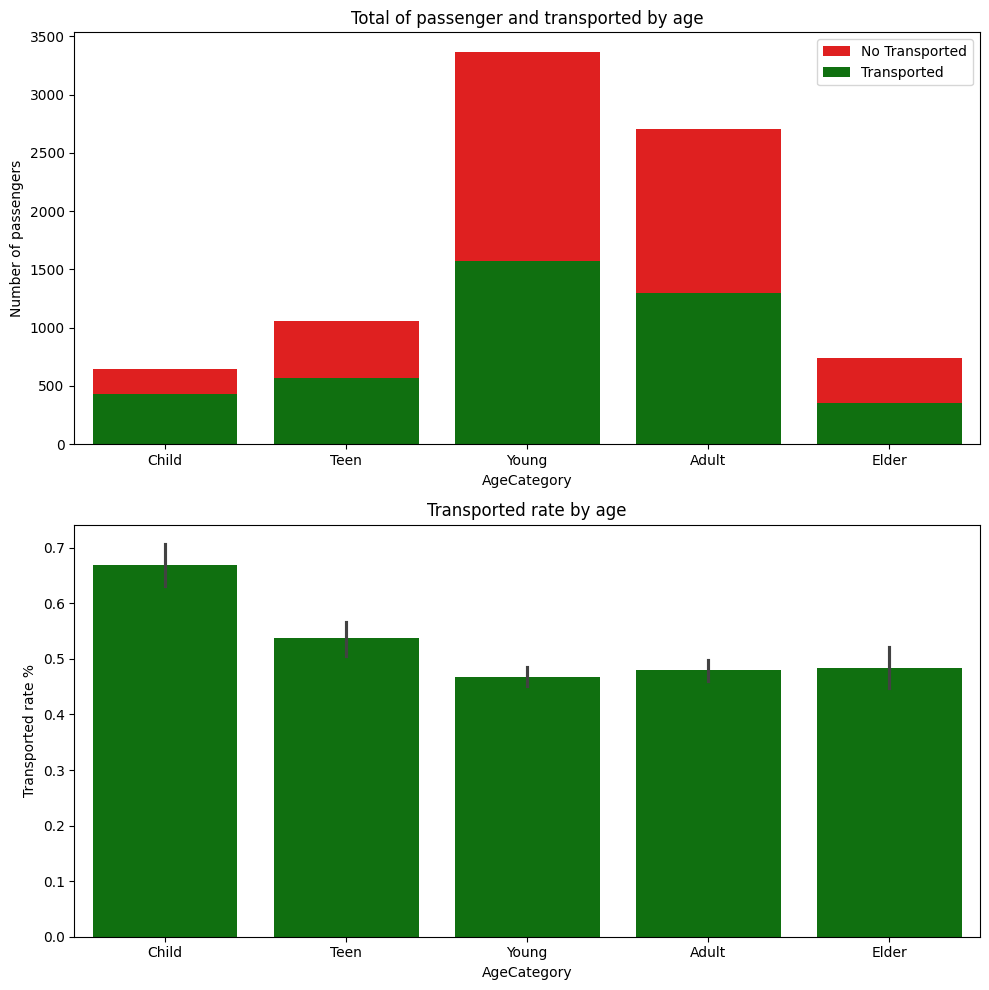

In [98]:
age_stats = train_df.groupby('AgeCategory', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=age_stats.index, y=age_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=age_stats.index, y=age_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by age')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='AgeCategory', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by age')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by Solo

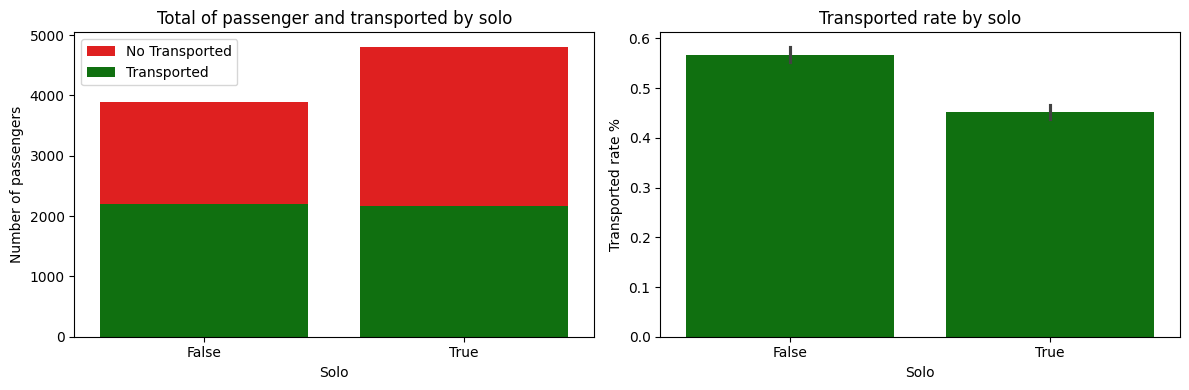

In [99]:
solo_stats = train_df.groupby('Solo', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=solo_stats.index, y=solo_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=solo_stats.index, y=solo_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by solo')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Solo', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by solo')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by GroupSize

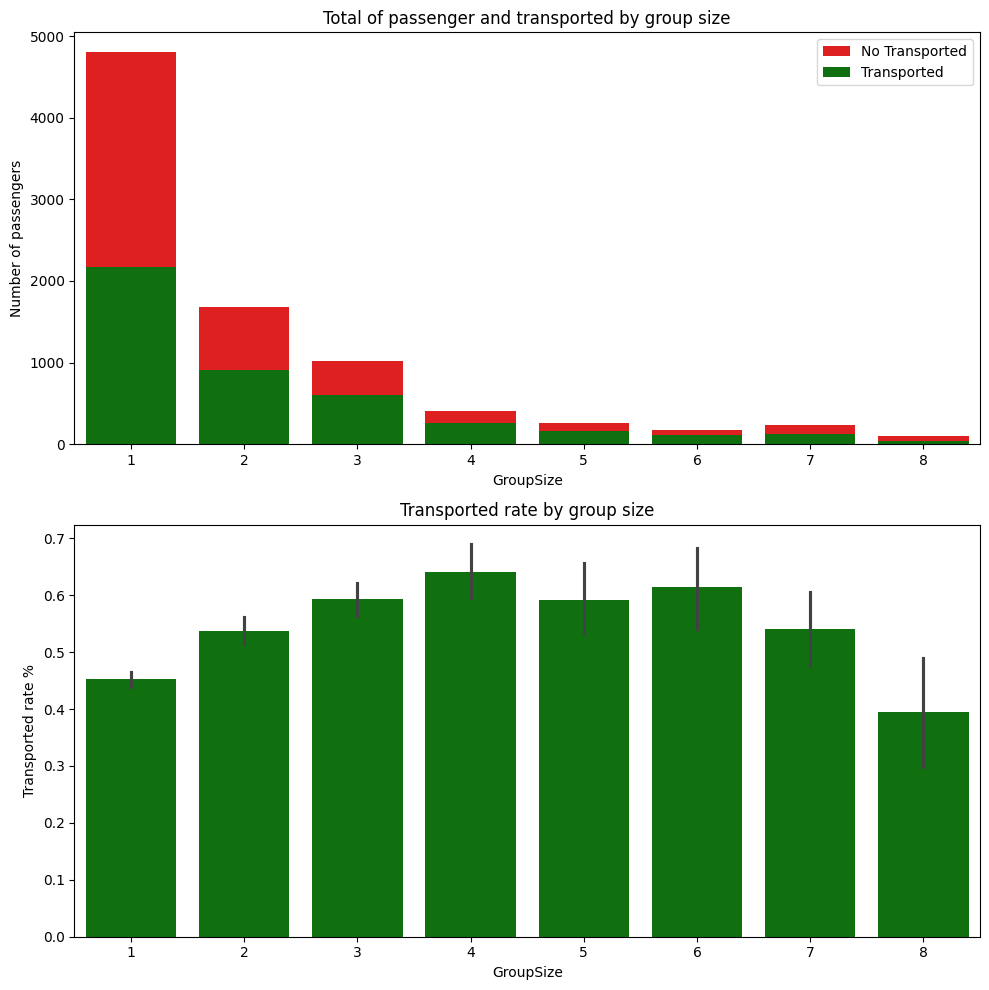

In [100]:
group_stats = train_df.groupby('GroupSize', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=group_stats.index, y=group_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=group_stats.index, y=group_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by group size')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='GroupSize', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by group size')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CryoSleep

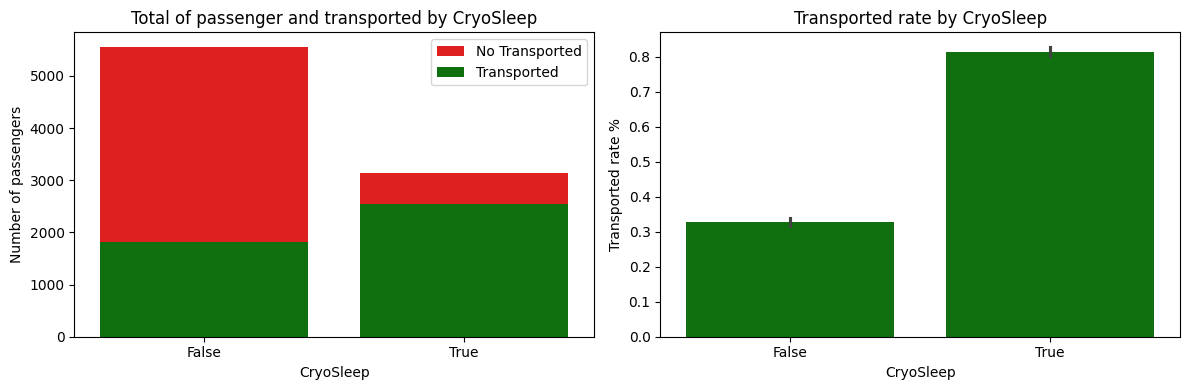

In [101]:
cryosleep_stats = train_df.groupby('CryoSleep', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=cryosleep_stats.index, y=cryosleep_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=cryosleep_stats.index, y=cryosleep_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by CryoSleep')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='CryoSleep', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by CryoSleep')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by VIP

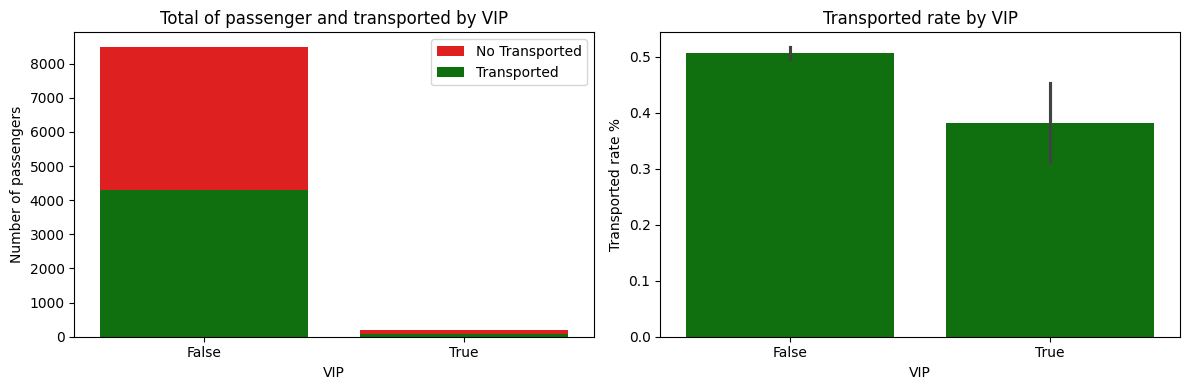

In [102]:
vip_stats = train_df.groupby('VIP', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=vip_stats.index, y=vip_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=vip_stats.index, y=vip_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by VIP')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='VIP', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by VIP')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by HomePlanet

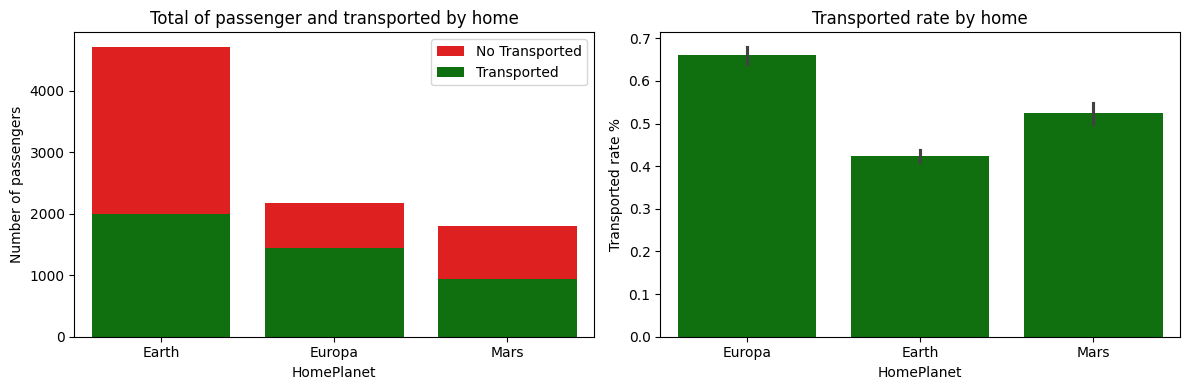

In [103]:
home_stats = train_df.groupby('HomePlanet', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=home_stats.index, y=home_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=home_stats.index, y=home_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by home')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='HomePlanet', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by home')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by Destination

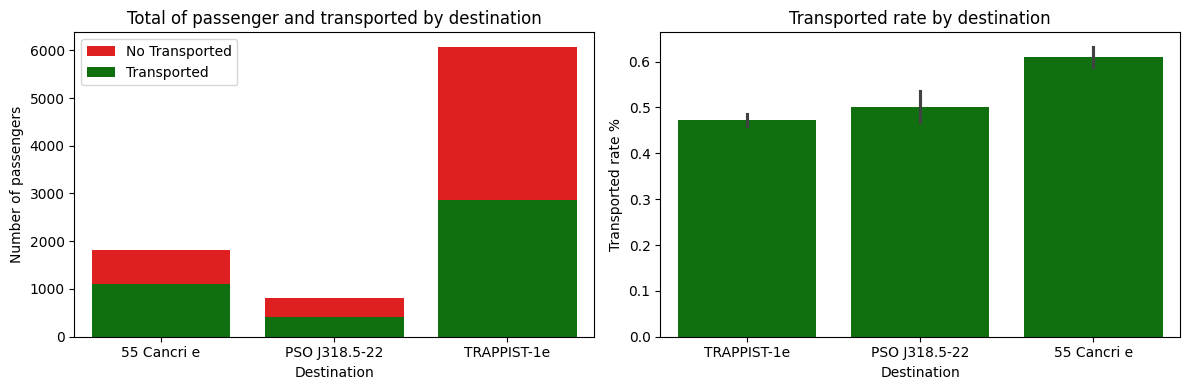

In [104]:
destination_stats = train_df.groupby('Destination', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=destination_stats.index, y=destination_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=destination_stats.index, y=destination_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by destination')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Destination', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by destination')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CabinSide

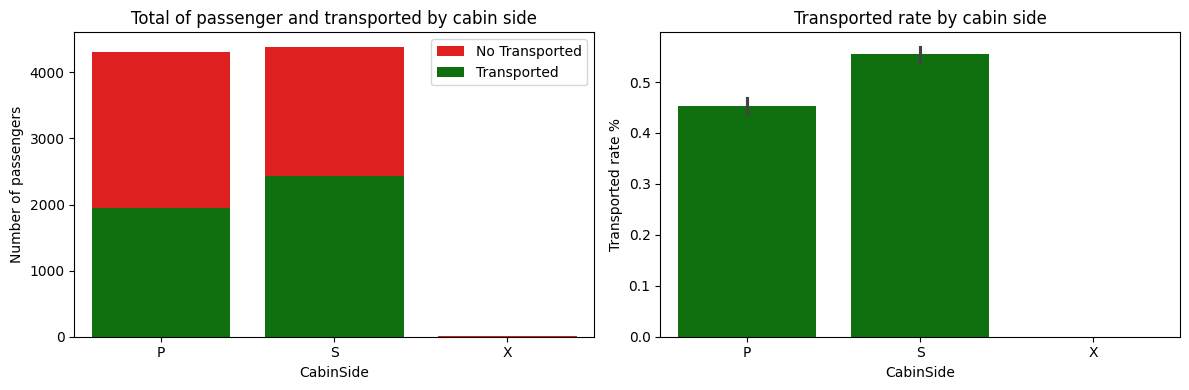

In [105]:
cabin_stats = train_df.groupby('CabinSide', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=cabin_stats.index, y=cabin_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=cabin_stats.index, y=cabin_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by cabin side')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='CabinSide', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by cabin side')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CabinDeck

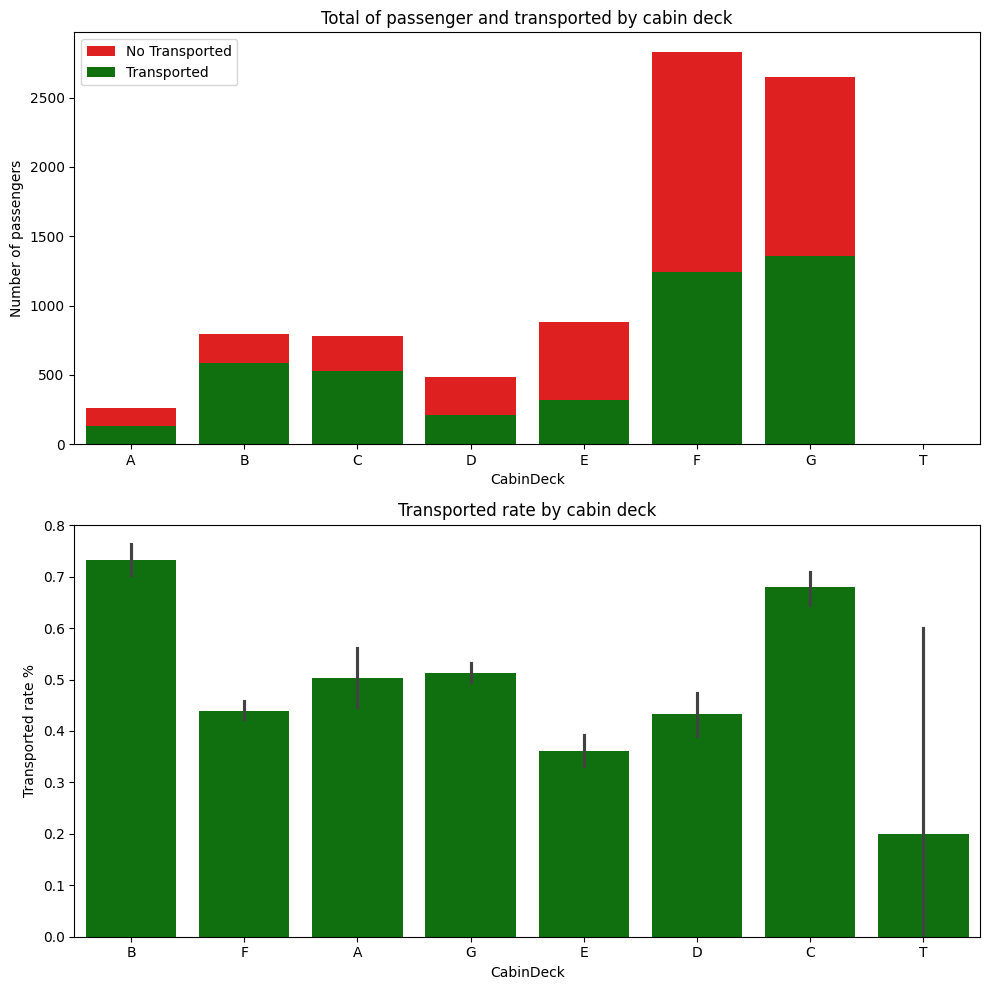

In [106]:
cabin_stats = train_df.groupby('CabinDeck', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=cabin_stats.index, y=cabin_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=cabin_stats.index, y=cabin_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by cabin deck')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='CabinDeck', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by cabin deck')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CabinDeck and CabinSide

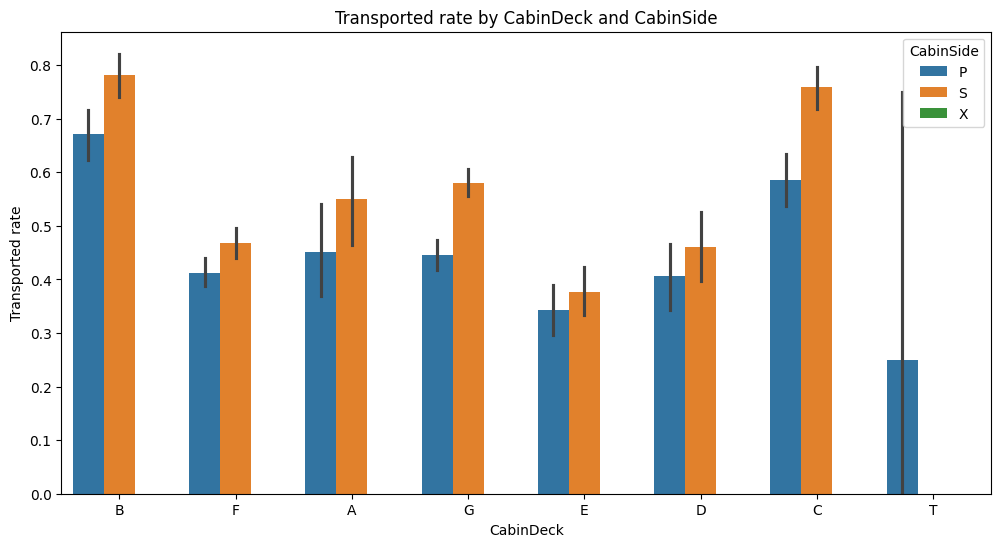

In [107]:
plt.figure(figsize=(12,6))
sns.barplot(x='CabinDeck', y='Transported', hue='CabinSide', data=train_df)
plt.title('Transported rate by CabinDeck and CabinSide')
plt.ylabel('Transported rate')
plt.show()

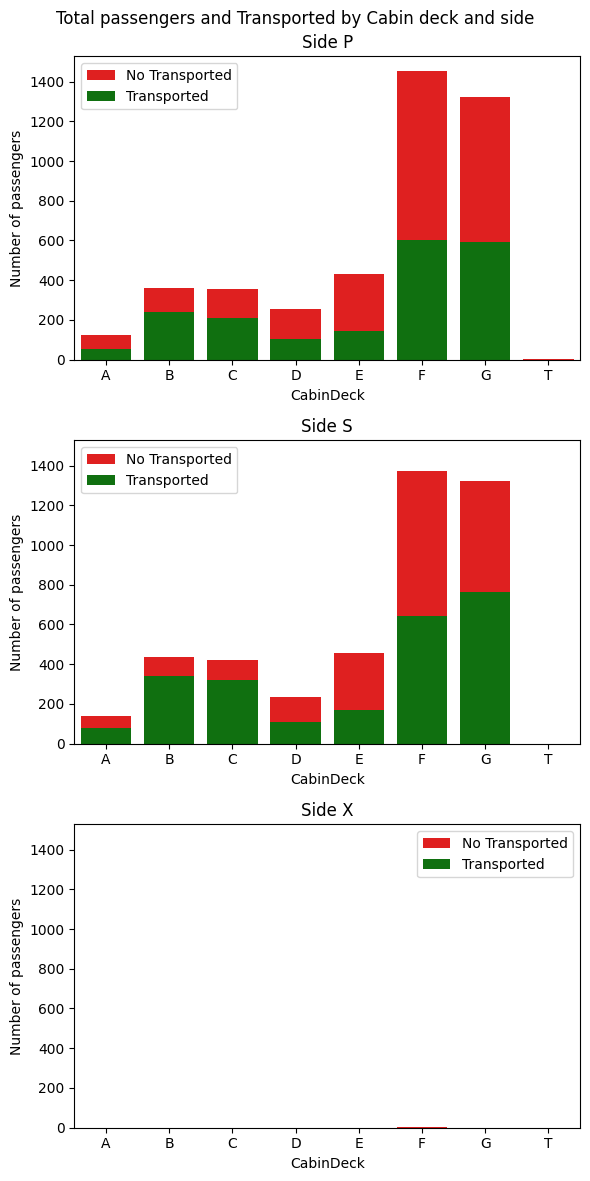

In [108]:
deck_side_stats = train_df.groupby(['CabinSide','CabinDeck'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(deck_side_stats.index):
    ax = axes[i]
    transported = deck_side_stats.loc[cls]['transported']
    total = deck_side_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'Side {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by Cabin deck and side')

plt.tight_layout()
plt.show()

#### Transported Rate by Age and CryoSleep

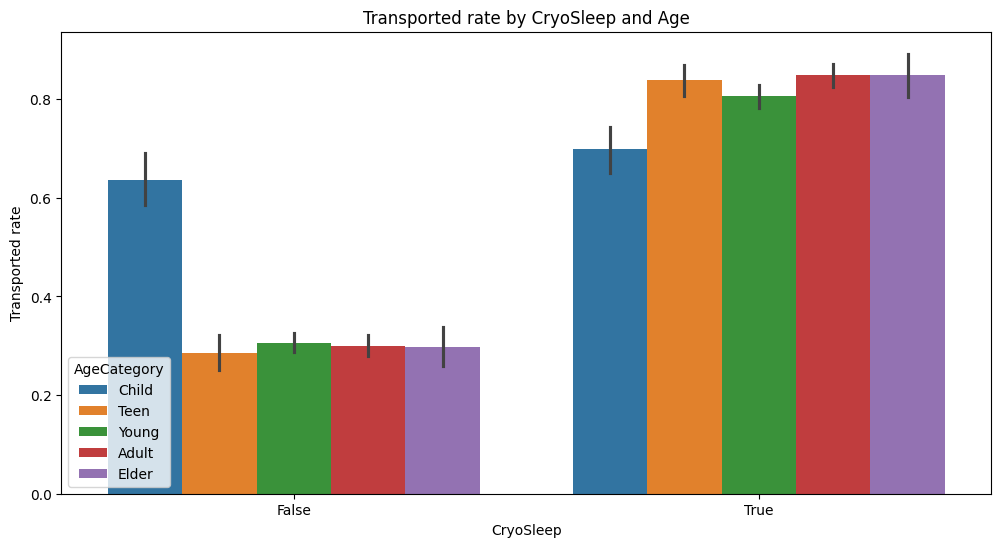

In [109]:
plt.figure(figsize=(12,6))
sns.barplot(x='CryoSleep', y='Transported', hue='AgeCategory', data=train_df)
plt.title('Transported rate by CryoSleep and Age')
plt.ylabel('Transported rate')
plt.show()

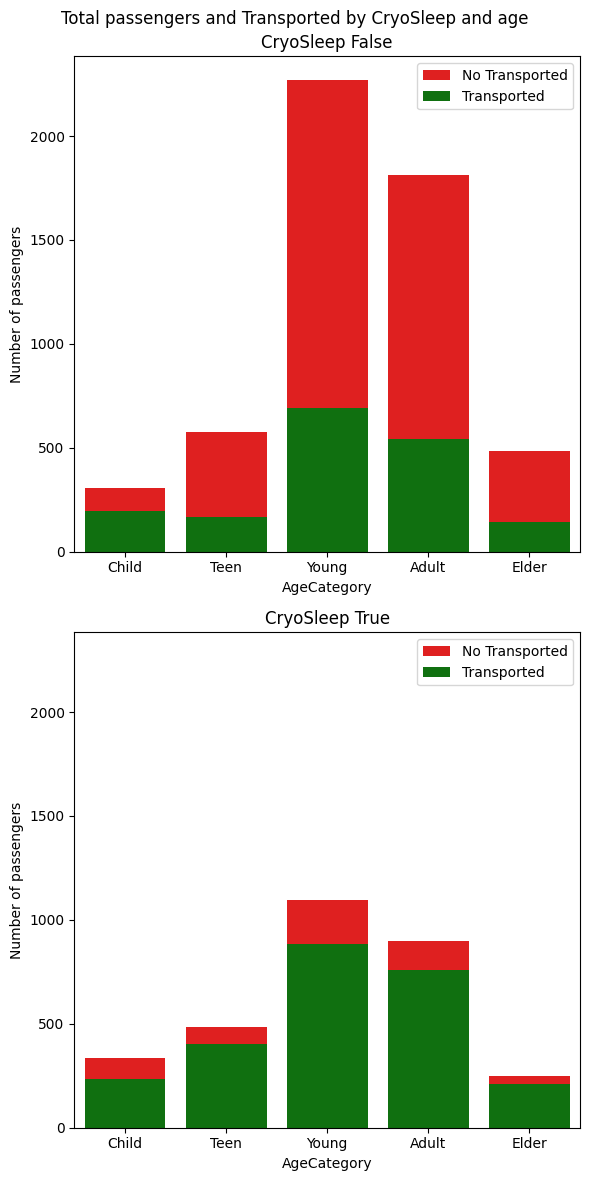

In [110]:
cryo_age_stats = train_df.groupby(['CryoSleep','AgeCategory'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(2, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(cryo_age_stats.index):
    ax = axes[i]
    transported = cryo_age_stats.loc[cls]['transported']
    total = cryo_age_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'CryoSleep {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by CryoSleep and age')

plt.tight_layout()
plt.show()

#### Transported Rate by Age and Solo

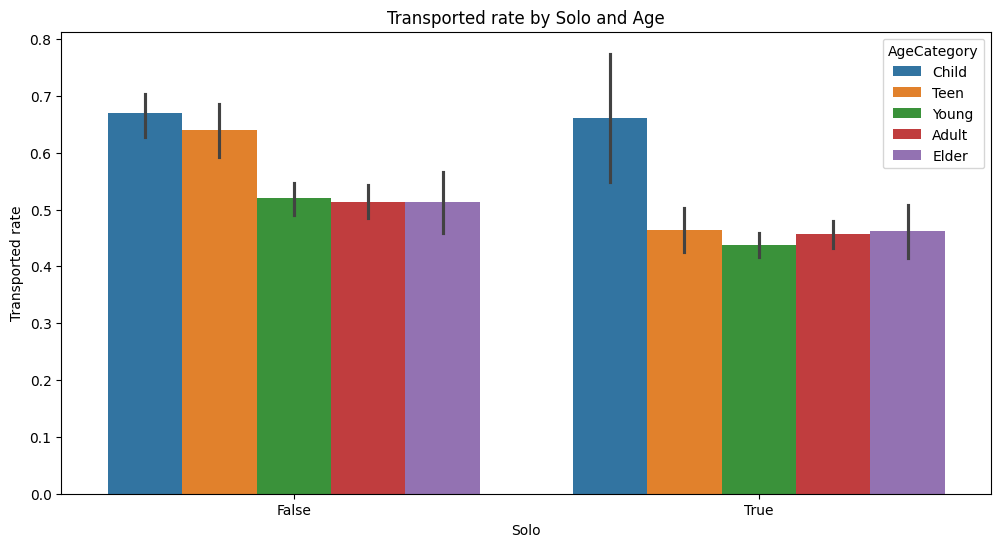

In [111]:
plt.figure(figsize=(12,6))
sns.barplot(x='Solo', y='Transported', hue='AgeCategory', data=train_df)
plt.title('Transported rate by Solo and Age')
plt.ylabel('Transported rate')
plt.show()

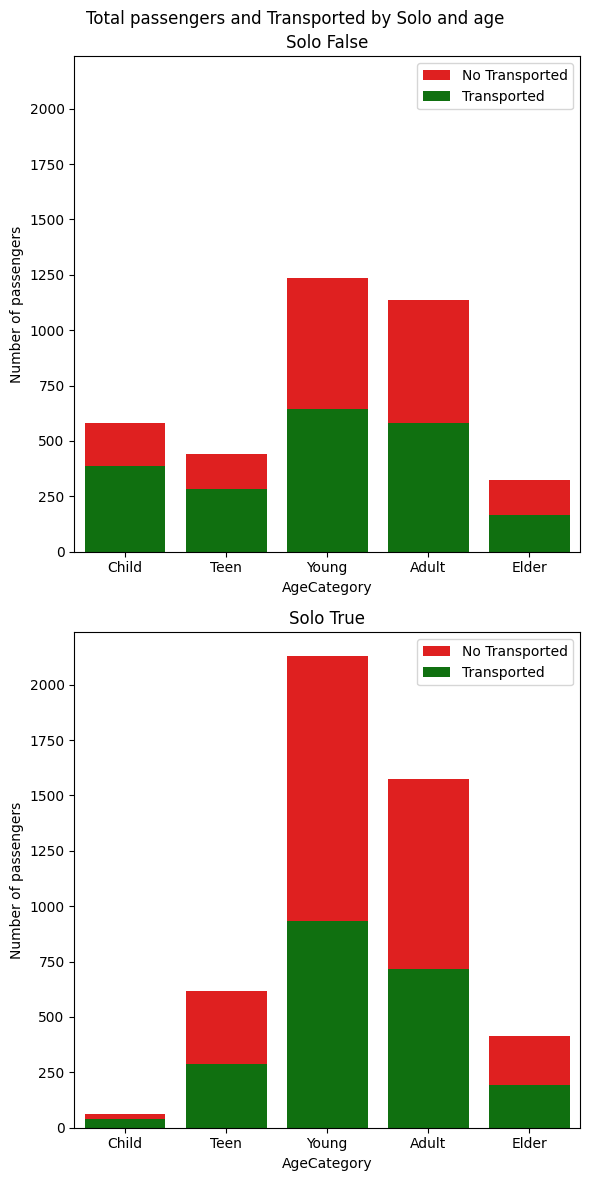

In [112]:
solo_age_stats = train_df.groupby(['Solo','AgeCategory'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(2, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(solo_age_stats.index):
    ax = axes[i]
    transported = solo_age_stats.loc[cls]['transported']
    total = solo_age_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'Solo {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by Solo and age')

plt.tight_layout()
plt.show()

#### Transported Rate by Home and Destination

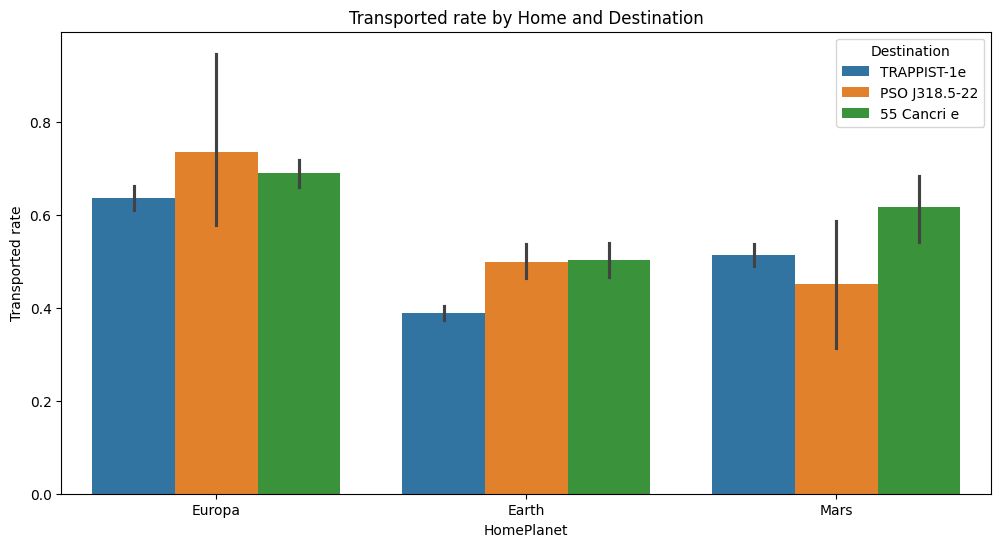

In [113]:
plt.figure(figsize=(12,6))
sns.barplot(x='HomePlanet', y='Transported', hue='Destination', data=train_df)
plt.title('Transported rate by Home and Destination')
plt.ylabel('Transported rate')
plt.show()

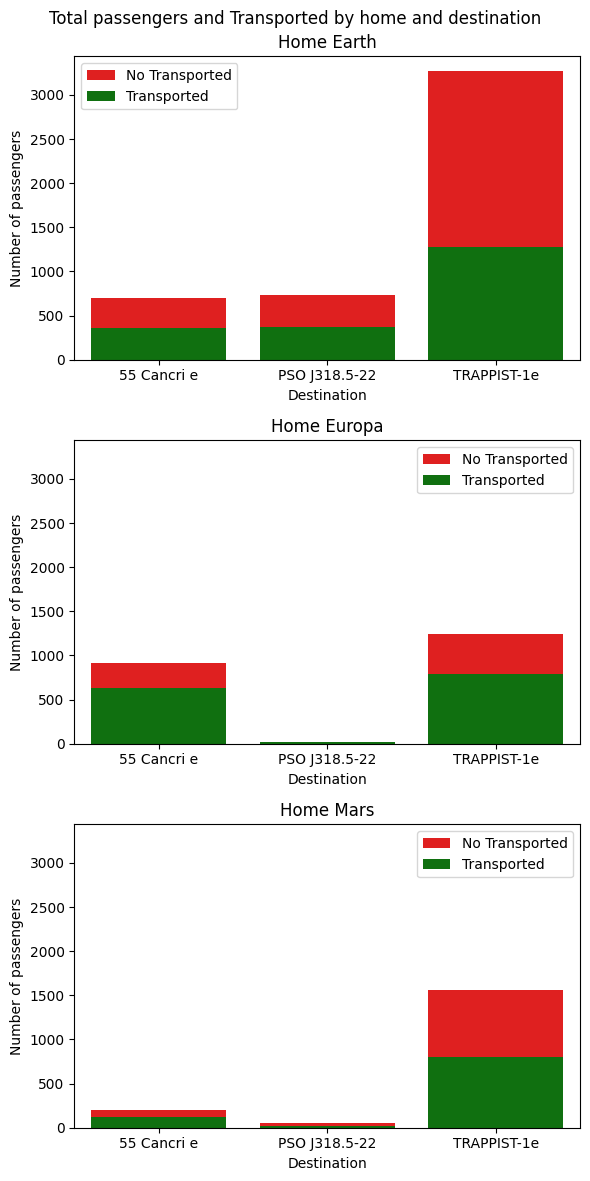

In [114]:
home_dest_stats = train_df.groupby(['HomePlanet','Destination'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(home_dest_stats.index):
    ax = axes[i]
    transported = home_dest_stats.loc[cls]['transported']
    total = home_dest_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'Home {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by home and destination')

plt.tight_layout()
plt.show()

## Model Development and Training

For the modeling phase, an Automated Machine Learning (AutoML) approach was adopted to efficiently optimize model selection and hyperparameter tuning. Rather than relying on manually designed pipelines, AutoML leverages automation to evaluate a wide range of algorithms and configurations, building robust ensemble models that maximize predictive performance while minimizing human intervention.

This approach offers several advantages: it reduces the time and expertise required to build effective models, helps prevent human bias in model selection, and systematically explores a wide range of algorithms and configurations that might otherwise be overlooked. By relying on automation, we can focus our efforts on understanding the data and interpreting the results rather than on repetitive model tuning.

In particular, this project employs AutoGluon, an advanced open-source AutoML framework developed by Amazon Web Services (AWS). AutoGluon is designed for high-performance model training and ensembling, providing automated optimization strategies that often outperform manually tuned models. It streamlines the entire machine learning workflow — from preprocessing to model stacking — while providing integrated performance optimization and model evaluation.

In [115]:
# Making a clean df for the training with less features
train_clean_df = train_df.copy()
test_clean_df = test_df.copy()

delete_columns = ['PassengerId', 'Spent']

train_clean_df = train_clean_df.drop(columns = delete_columns)
test_clean_df = test_clean_df.drop(columns = delete_columns)

In [229]:
# Building and training the predictor with autogluon
predictor = TabularPredictor(label='Transported', eval_metric='accuracy')
predictor.fit(train_data=train_clean_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20251112_191711"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.54 GB / 31.35 GB (94.2%)
Disk Space Avail:   19.20 GB / 19.52 GB (98.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU mem

In [230]:
# Best trained models
predictor.leaderboard(train_clean_df)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestGini,0.978373,0.787356,accuracy,0.193276,0.102137,1.853483,0.193276,0.102137,1.853483,1,True,3
1,RandomForestEntr,0.977683,0.780460,accuracy,0.226843,0.089344,2.165796,0.226843,0.089344,2.165796,1,True,4
2,ExtraTreesGini,0.977108,0.774713,accuracy,0.277624,0.100449,1.205021,0.277624,0.100449,1.205021,1,True,6
3,ExtraTreesEntr,0.976763,0.771264,accuracy,0.319732,0.099390,1.205627,0.319732,0.099390,1.205627,1,True,7
4,LightGBMLarge,0.901185,0.798851,accuracy,0.043218,0.007122,2.080337,0.043218,0.007122,2.080337,1,True,10
5,LightGBM,0.887841,0.808046,accuracy,0.084106,0.011459,1.046015,0.084106,0.011459,1.046015,1,True,2
6,XGBoost,0.882204,0.802299,accuracy,0.086085,0.012646,1.321552,0.086085,0.012646,1.321552,1,True,9
7,LightGBMXT,0.848959,0.808046,accuracy,0.088626,0.016278,1.080511,0.088626,0.016278,1.080511,1,True,1
8,CatBoost,0.836420,0.820690,accuracy,0.020897,0.006371,7.113719,0.020897,0.006371,7.113719,1,True,5
9,WeightedEnsemble_L2,0.836420,0.820690,accuracy,0.023252,0.007216,7.188445,0.002355,0.000845,0.074726,2,True,11


In [231]:
# Making predictions and saving to CSV
predictions = predictor.predict(test_clean_df)

submission_stack = pd.DataFrame({
    'PassengerId': test_df["PassengerId"],
    'Transported': predictions})

submission_stack.to_csv('submission_auto.csv', index=False)

## Conclusions and Insights

This project represents a significant step up from the classic Titanic survival prediction challenge, presenting a more complex and multifaceted task. The Spaceship Titanic dataset is diverse and comprehensive, but it also requires careful handling of missing values — a crucial step for ensuring the models perform correctly.

One aspect that makes this challenge particularly valuable for an end-to-end machine learning project is the distribution of the target variable. With approximately 50% of cases being transported, it provides a clear baseline for model performance: any model achieving above 50% accuracy is outperforming a purely random classifier. This contrasts with the original Titanic dataset, where the majority of passengers did not survive, making the baseline less informative.

A key decision in this project was the adoption of AutoML, specifically using AutoGluon. This advanced library greatly simplifies the model creation and training process. The choice was made after testing multiple traditional machine learning models built with scikit-learn, none of which exceeded a 0.8 score on the competition leaderboard — the initial target for this project. By leveraging AutoGluon, the final model achieved an accuracy above 81%, placing it in the top 2% of the Kaggle leaderboard, a strong and satisfying result.

Potential improvements could involve fine-tuning certain stages, such as creating additional features through feature engineering or experimenting with alternative strategies for imputing missing values. However, given that the highest scores on the leaderboard do not surpass 82%, significant gains may be limited, and further effort might yield only marginal improvements.